In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from matplotlib.colors import LogNorm
import csv

In [2]:
from model_pvp import model_pvp
from generate_distribution import generate_distribution
from make_prob_matrix import make_prob_matrix

In [3]:
from digitalize_states import digitalize_states
import get_games_strategy

In [54]:
a = np.zeros((5, 5))
a[tuple([[0, 1], [2, 0]])] = 3
a

array([[0., 0., 3., 0., 0.],
       [3., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [105]:
N = 16

counts_pvp = np.load('../data/qr_counts_pvp.npy')
counts_pvp_400 = np.load('../data/qr_counts_pvp_400.npy')

qr_pve_border = np.load('../data/qr_pve_border.npy')
qr_pve_center = np.load('../data/qr_pve_center.npy')
qr_pvp = np.load('../data/qr_pvp.npy')
qr_pvp_400 = np.load('../data/qr_pvp_400.npy')

strategy_pve_center = np.load('../data/strategy_pve_center.npy')
strategy_pve_border = np.load('../data/strategy_pve_border.npy')
strategy_random = np.ones ((N + 1, N + 1), dtype=np.float64) * 0.5

strategy_pvp_border = np.load('../data/strategy_pvp_border.npy')
strategy_pvp_center = np.load('../data/strategy_pvp_center.npy')

strategy_pvp_400_border = np.load('../data/strategy_pvp_400_border.npy')
strategy_pvp_400_center = np.load('../data/strategy_pvp_400_center.npy')

strategy_pve_border_optimal = np.zeros ((N + 1, N + 1), dtype=np.float64)
strategy_pve_center_optimal = np.zeros ((N + 1, N + 1), dtype=np.float64)
strategy_pve_center_optimal = \
    np.diag(np.ones(N + 1) * 0.5) + \
    np.diag(np.ones(N), -1) + \
    np.diag(np.zeros(N), +1)
strategy_pve_center_optimal = strategy_pve_center_optimal.T

strategy_pve_center_optimal_2d = np.zeros ((N + 1, N + 1), dtype=np.float64)
strategy_pve_center_optimal_2d[1:N, 1] = 1
#strategy_pve_center_optimal_2d[:, N - 1] = 1
#strategy_pve_center_optimal_2d[1, :] = 1
strategy_pve_center_optimal_2d[N - 1, 1:N] = 1
strategy_pve_center_optimal_2d = strategy_pve_center_optimal_2d.T

qr_bvb, probabilities = make_prob_matrix(N, strategy_random, strategy_random)
qr_pve_border_pure, probabilities = make_prob_matrix(N, strategy_random, strategy_pve_border)
qr_pve_center_pure, probabilities = make_prob_matrix(N, strategy_pve_center, strategy_random)
qr_pvp_pure, probabilities = make_prob_matrix(N, strategy_pvp_center, strategy_pvp_border)
qr_pvp_400_pure, probabilities = make_prob_matrix(N, strategy_pvp_400_center, strategy_pvp_400_border)

qr_pve_border_optimal, probabilities = make_prob_matrix(N, strategy_random, strategy_pve_border_optimal)
qr_pve_center_optimal, probabilities = make_prob_matrix(N, strategy_pve_center_optimal, strategy_random)
qr_pve_center_optimal_2d, probabilities = make_prob_matrix(N, strategy_pve_center_optimal_2d, strategy_random)

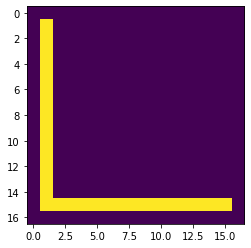

In [103]:
plt.imshow(strategy_pve_center_optimal_2d.T)

In [84]:
x, y = 8, 9
qr_pve_center_optimal[(N+1) * x + y, (N+1) * (x - 0) + (y + 1)]

0.0

In [109]:
qrs = {
    'pve_border': qr_pve_border,
    'pve_center': qr_pve_center,
    'bvb': qr_bvb,
    'pve_border_pure': qr_pve_border_pure,
    'pve_center_pure': qr_pve_center_pure,
    'pvp': qr_pvp,
    'pvp_pure': qr_pvp_pure,
    'pvp_400': qr_pvp_400,
    'pvp_400_pure': qr_pvp_400_pure,
    'pve_border_optimal': qr_pve_border_optimal,
    'pve_center_optimal': qr_pve_center_optimal,
    'pve_center_optimal_2d': qr_pve_center_optimal_2d,
}

In [110]:
turns = np.arange(0, len(prob))
probs = {}
stats = {}
for name, qr in qrs.items():
    d, prob, (even, odd) = model_pvp(N, qr)
    mean_time = np.dot(prob, turns)
    probs['model_' + name] = prob
    stats['model_' + name] = {'even': even, 'odd': odd, 'mean_time': mean_time}

In [108]:
stats

{'model_pve_border_optimal': {'even': 0.9999999999999986,
  'odd': 0.0,
  'mean_time': 64.00000000000001},
 'model_pve_center_optimal': {'even': 0.0,
  'odd': 0.9999999999999922,
  'mean_time': 224.9999999999999},
 'model_pve_center_optimal_2d': {'even': 0.0,
  'odd': 0.9999999999999923,
  'mean_time': 224.99999999999994}}

In [111]:
turn_bins = np.arange(0, len(prob) + 1)
for name, qr in qrs.items():
    gen_turns = generate_distribution(N, qr, return_games=False)
    prob_gen, _ = np.histogram(gen_turns, bins=turn_bins, density=True)
    odd = np.mean(np.array(gen_turns) % 2)
    even = 1 - odd
    mean_time = np.mean(gen_turns)
    probs['simulation_' + name] = prob_gen
    stats['simulation_' + name] = {'even': even, 'odd': odd, 'mean_time': mean_time}

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:09<00:00, 1446.05it/s]


In [112]:
probs['turns'] = np.arange(0, len(prob))

In [113]:
df_time_prob = pd.DataFrame(probs)
df_time_prob.to_excel('../data/absorption_time_pmf.xlsx')

In [117]:
df_stats_prob = pd.DataFrame(stats).T
df_stats_prob.to_excel('../data/absorption_time_stats.xlsx')

In [ ]:
def g_test(N, counts):
    import scipy
    import itertools
    pvalues = np.zeros((N+1, N+1), dtype=np.float64)
    for i, j in itertools.product(range(1, N), range(1, N)):
        cont_table = np.array([[0, 0], [0, 0]], dtype=np.float64)
        expected_table = np.array([[0, 0], [0, 0]], dtype=np.float64)
        shifts     = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        strategies = [(1, 1), (0, 1), (0, 0), (1, 0)]
        for (dx, dy), (ii, jj) in zip(shifts, strategies):
            st = i * (N+1) + j
            fn = (i + dx) * (N+1) + (j + dy)
            cont_table[ii][jj] = counts[st][fn]
        try:
            g, p, dof, expctd = scipy.stats.chi2_contingency(cont_table)
        except:
            p = 1
            g = 0
        pvalues[i, j] = p
    return pvalues
import matplotlib
pvalues = g_test(N, counts_pvp_400)
plt.imshow(pvalues, norm=matplotlib.colors.LogNorm(), vmin=1e-2)
plt.colorbar()